In [1]:
# Author: Tapopriya Majumdar

In [1]:
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

%matplotlib inline

## 1.

In [2]:
######## Functions defined in Part 5, used here to enable polynomial regression ###########

def partitions(n, k):
    """Finds all nennegative partitions of a number n into b parts"""
    assert (isinstance(n, int) & (n > 0)), "n needs to be a positive integer"
    assert (isinstance(k, int) & (k > 0)), "n needs to be a positive integer"
    masks = np.identity(k, dtype=int)
    for c in combinations_with_replacement(masks, n): 
        yield sum(c)

def preprocess(X, l=1):
    """Adds monomials of orders {2, 3,..., l} to the given data"""
    n = X.shape[1]
    monomials = [np.prod(X ** a, axis=1).reshape(-1, 1) for j in range(2, l+1) for a in partitions(j, n)]
    return np.hstack([X] + monomials)

##########################################################################################

class RegressionGradient:
    """
    Our Implementation of Ridge Regression
    with Gradient Descent
    """
    
    def __init__(self, lmbda=1.0, step_size=1e-3, 
                 n_iter=1e6, epsilon=1e-4, l=1):
        """Initialize with dimension and lambda"""
        self._lambda = lmbda
        self._step_size = step_size
        self._n_iter = n_iter
        self._epsilon = epsilon
        self._w = None
        self._b = None
        self._l = l
        # TODO: check parameters for validity
        self._is_trained = False

    def __str__(self):
        """string representation"""
        assert self._is_trained, "Model not yet trained!"
        return "<b = " + str(self._b) + ", w = " + str(self._w) + ">"
    
    def _risk_gradient(self, X, y):
        """Computes the gradient of the risk function given the data"""
        theta = np.hstack((self._b, self._w))
        return np.sum(((X @ theta.reshape(-1,1)) - y.reshape(-1,1)) * 2 * X, axis=0) \
                + 2 * self._lambda * np.hstack((0, theta[1:]))
    
    def _update_params(self, X, y):
        """Single step update of wieght and bias parameters"""
        theta = np.hstack((self._b, self._w))
        theta = theta - self._step_size * self._risk_gradient(X, y) 
        self._w, self._b = theta[1:], theta[0]
        
    def _reset_params(self, n):
        """
        Takes a dimension, resets the bias and weight parameters
        in that dimension, and return an array of infinite values as 
        old weights
        """
        self._b = -0.2 + 0.4 * np.random.random_sample()
        self._w = -0.2 + 0.4 * np.random.random_sample(n-1)   
        return np.array([np.inf] * n)
        
    def train(self, data):
        """Trains the model to find optimal wieght and bias parameters"""
        assert (isinstance(data, np.ndarray) & (np.ndim(data) == 2)), \
                    "The training data has to be a two dimensional array"
        print("Starting the training process with stepsize = %0.1e and lambda = %0.1e" % (self._step_size, self._lambda))
        # use ploynomial regression if l > 1
        X = np.hstack((np.ones((data.shape[0], 1)), preprocess(data[:, :-1], self._l)))
        y = data[:, -1]
        theta_old = self._reset_params(X.shape[1])
        i = 1
        # train using gradient descent
        while True:
            theta = np.hstack((self._b, self._w))
            with np.errstate(over='raise'):
                try:
                    norm_grad = np.sum(self._risk_gradient(X, y) ** 2)
                # adjust the stepsize, if required
                except FloatingPointError:
                    self._step_size /= 2      
                    theta_old = self._reset_params(X.shape[1])
                    print("Error found after %d iterations. Retrying with new stepsize = %0.1e" % (i, self._step_size))
                    i = 1
                    continue
            # convergence
            if (norm_grad < self._epsilon) | (i >= self._n_iter):
                self._is_trained = True
                print("Model converged after %d iterations.\n\tOptimal parameters: bias = %r, weight = %r" % 
                                                                                                  (i, self._b, self._w))
                break
            # if not update theta and continue
            theta_old = theta
            self._update_params(X, y)
            i += 1
            
    def get_params(self):
        """Returns the weight and bias parameters"""
        assert self._is_trained, "Model needs to be trained first!"
        return self._b, self._w
    
    def predict(self, X):
        """Returns the data predictions"""
        assert self._is_trained, "Model needs to be trained first!"
        # preprocess if necessary, then add bias and do X^T * theta
        return (np.hstack((np.ones((X.shape[0], 1)), preprocess(X, self._l)))
                                        @ np.hstack((self._b, self._w)).reshape(-1,1)).ravel()

    def quadratic_loss(self, data):
        """Calculates the average quadratic function"""
        X = np.hstack((np.ones((data.shape[0], 1)), preprocess(data[:, :-1], self._l)))
        y = data[:, -1]
        theta = np.hstack((self._b, self._w))
        return (np.sum(((X @ theta.reshape(-1,1)) - y.reshape(-1,1)) ** 2) \
                    + self._lambda * np.sum(self._w ** 2)) / len(y)
    
    #Graph of the trainig data set and the trained output 

## 2

In [7]:
def h(x):
    return np.sin(x) + 0.3 * x - 1

* Generate $D_n$

In [8]:
def generate_data(n=15, X_MIN=-5, X_MAX=5):
    return np.array([[x, h(x)] for x in scs.uniform(X_MIN, X_MAX - X_MIN).rvs(n)])
D_n = generate_data()

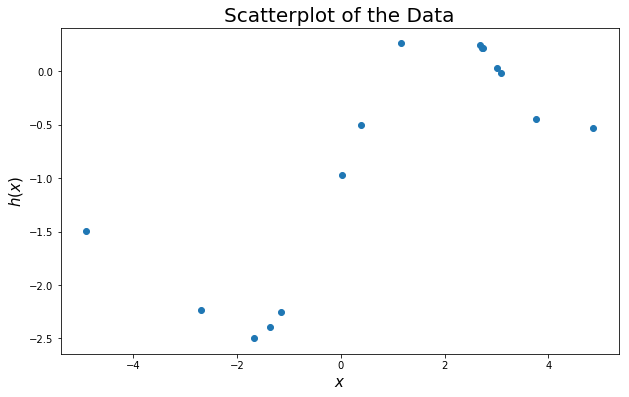

In [6]:
plt.figure(figsize=(10,6))
plt.title("Scatterplot of the Data", fontsize=20)
plt.xlabel("$x$", fontsize=15)
plt.ylabel("$h(x)$", fontsize=15)
plt.scatter(D_n[:, 0], D_n[:, 1])
plt.savefig('q2plot')

## 3, 4

* Take $\lambda = 0$ and an intermediate and a big value for $\lambda$, then train those models

In [7]:
lambdas = [0, 5, 100]

In [8]:
reg1 = RegressionGradient(lmbda=lambdas[0])
reg1.train(D_n)
b1, w1 = reg1.get_params()

Starting the training process with stepsize = 1.0e-03 and lambda = 0.0e+00
Model converged after 292 iterations.
	Optimal parameters: bias = -1.0728473499014801, weight = array([ 0.29546344])


In [9]:
reg2 = RegressionGradient(lmbda=lambdas[1])
reg2.train(D_n)
b2, w2 = reg2.get_params()

Starting the training process with stepsize = 1.0e-03 and lambda = 5.0e+00
Model converged after 290 iterations.
	Optimal parameters: bias = -1.061697483707954, weight = array([ 0.28222448])


In [10]:
reg3 = RegressionGradient(lmbda=lambdas[2])
reg3.train(D_n)
b3, w3 = reg3.get_params()

Starting the training process with stepsize = 1.0e-03 and lambda = 1.0e+02
Model converged after 277 iterations.
	Optimal parameters: bias = -0.952316868744986, weight = array([ 0.15243807])


* Plot the three lines

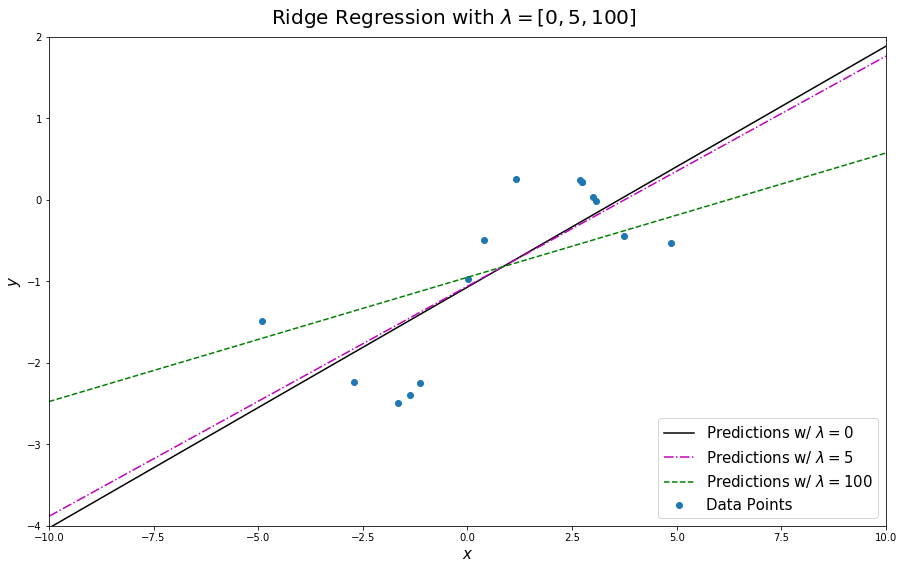

In [11]:
x1 = np.linspace(-10, 10, 100)
y1 = b1 + w1[0] * x1
y2 = b2 + w2[0] * x1
y3 = b3 + w3[0] * x1
plt.figure(figsize=(15,9))
plt.figtext(0.5, 0.90, 'Ridge Regression with $\lambda = %r$' % lambdas, fontsize=20, ha='center')
#plt.figtext(0.5, 0.89, 'bias = %0.3f, weights = %s'  % (b1, str(np.round(w1, 3))), fontsize=15, ha='center')
plt.xlim((-10,10))
plt.ylim((-4,2))
plt.xlabel("$x$", fontsize=15)
plt.ylabel("$y$", fontsize=15)
plt.plot(x1, y1, 'k-', label="Predictions w/ $\lambda = %r$" % reg1._lambda)
plt.scatter(D_n[:, 0], D_n[:, 1], label="Data Points")
plt.plot(x1, y2, 'm-.', label="Predictions w/ $\lambda = %r$" % reg2._lambda)
plt.plot(x1, y3, 'g--', label="Predictions w/ $\lambda = %r$" % reg3._lambda)
plt.legend(loc=4, prop={'size': 15})
plt.savefig('q3-4plot')

Please see the explanation on the PDF report

* (aside) compare our results with analytical results and using sklearn

In [12]:
# check answres with sklearn and normal equation
from sklearn.linear_model import LinearRegression
lin = LinearRegression().fit(D_n[:, :-1], D_n[:, 1])
X_n = np.hstack((np.ones((D_n.shape[0], 1)), D_n[:, :-1]))
y_n = D_n[:, -1]
theta_th = (np.linalg.inv(X_n.T @ X_n)
                         @ X_n.T @ y_n.reshape(-1,1)).ravel()
print("Parameters given by the analytical solution:", theta_th[0], theta_th[1:])
print("Parameters given by sklearn:", lin.intercept_, lin.coef_)
print("Parameters given by our model:", reg1._b, reg1._w)

Parameters given by the analytical solution: -1.07321460391 [ 0.29550818]
Parameters given by sklearn: -1.07321460391 [ 0.29550818]
Parameters given by our model: -1.0728473499 [ 0.29546344]


## 5

* Generate $D_{\rm{test}}$

In [13]:
D_test = generate_data(100)

* Calculate average loss on $D_\rm{test}$

In [14]:
losses = []
for lmbda in np.logspace(-4, 2, 7):
    reg = RegressionGradient(lmbda=lmbda)
    reg.train(D_n)
    losses.append(reg.quadratic_loss(D_test))

Starting the training process with stepsize = 1.0e-03 and lambda = 1.0e-04
Model converged after 293 iterations.
	Optimal parameters: bias = -1.0728548984406063, weight = array([ 0.29546411])
Starting the training process with stepsize = 1.0e-03 and lambda = 1.0e-03
Model converged after 288 iterations.
	Optimal parameters: bias = -1.0728459513592057, weight = array([ 0.29546078])
Starting the training process with stepsize = 1.0e-03 and lambda = 1.0e-02
Model converged after 289 iterations.
	Optimal parameters: bias = -1.0728256204423099, weight = array([ 0.29543592])
Starting the training process with stepsize = 1.0e-03 and lambda = 1.0e-01
Model converged after 288 iterations.
	Optimal parameters: bias = -1.0726172734546489, weight = array([ 0.29518688])
Starting the training process with stepsize = 1.0e-03 and lambda = 1.0e+00
Model converged after 287 iterations.
	Optimal parameters: bias = -1.0705338636916475, weight = array([ 0.29271713])
Starting the training process with steps

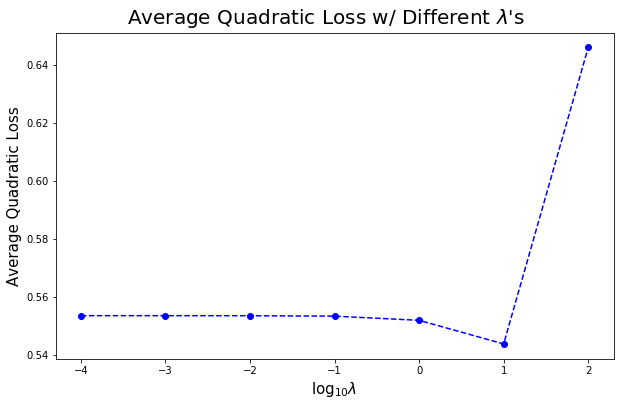

In [15]:
plt.figure(figsize=(10,6))
plt.figtext(0.5, 0.90, 'Average Quadratic Loss w/ Different $\lambda$\'s' % lambdas, fontsize=20, ha='center')
#plt.title("Average Quadratic Loss w/ Different $\lambda$'s")
plt.xlabel("$\log_{10} \lambda$", fontsize=15)
plt.ylabel("Average Quadratic Loss", fontsize=15)
plt.plot(range(-4,3), losses, 'bo--')
plt.savefig('q5plot')

## 6

* We use the preprocess function defined below to modify the given data while solving the normal equation. We also modify our class to store l as a private variable

In [16]:
def partitions(n, b):
    assert (isinstance(n, int) & (n > 0)), "n needs to be a positive integer"
    assert (isinstance(b, int) & (b > 0)), "b needs to be a positive integer"
    masks = np.identity(b, dtype=int)
    for c in combinations_with_replacement(masks, n): 
        yield sum(c)

def preprocess(X, l=1):
    """Adds monomials of order 2 to l to the given data"""
    #print([list(partitions(j, n)) for j in range(2, l+1)])
    monomials = [np.prod(X ** a, axis=1).reshape(-1, 1) for j in range(2, l+1) for a in partitions(j, X.shape[1])]
    #print(monomials)
    return np.hstack([X] + monomials)

* We define functions to find theta analytically and predict values for new data

In [17]:
def analytical_solution(data, lmbda=0.01, l=1):
    """Solve the normal equation and retrun the parameters"""
    assert (isinstance(data, np.ndarray) & (data.ndim == 2)), "Check data format!"
    X_n = np.hstack((np.ones((data.shape[0], 1)), preprocess(data[:, :-1], l)))
    y_n = data[:, -1]
    I = np.eye(X_n.shape[1])
    I[0,0] = 0.
    return (np.linalg.inv(X_n.T @ X_n + (lmbda * I))
                             @ X_n.T @ y_n.reshape(-1,1)).ravel()

def analytical_prediction(data, theta, l=1):
    """Returns the predicted values for polynomial regression"""
    assert (isinstance(data, np.ndarray) & (data.ndim == 2)), "Check data format!"
    X_n = np.hstack((np.ones((data.shape[0], 1)), preprocess(data[:, :-1], l)))
    return (X_n @ theta.reshape(-1,1)).ravel()

* Plot for different values of $\lambda$

In [18]:
def plot_pred_curve(data, l=1, ls='--', lw=1, X_MIN=-10, X_MAX=10, DELTA=0.2):
    """Takes the data and plots the prediction curve"""
    theta = analytical_solution(data, l=l)
    # we dont care about the y coordinates 
    test_data = np.array([[x,1] for x in np.arange(X_MIN, X_MAX, DELTA)])
    test_pred = analytical_prediction(test_data, theta, l=l)
    plt.plot(test_data[:, 0], test_pred, ls=ls, lw=lw, label="$l = %d$" % l)

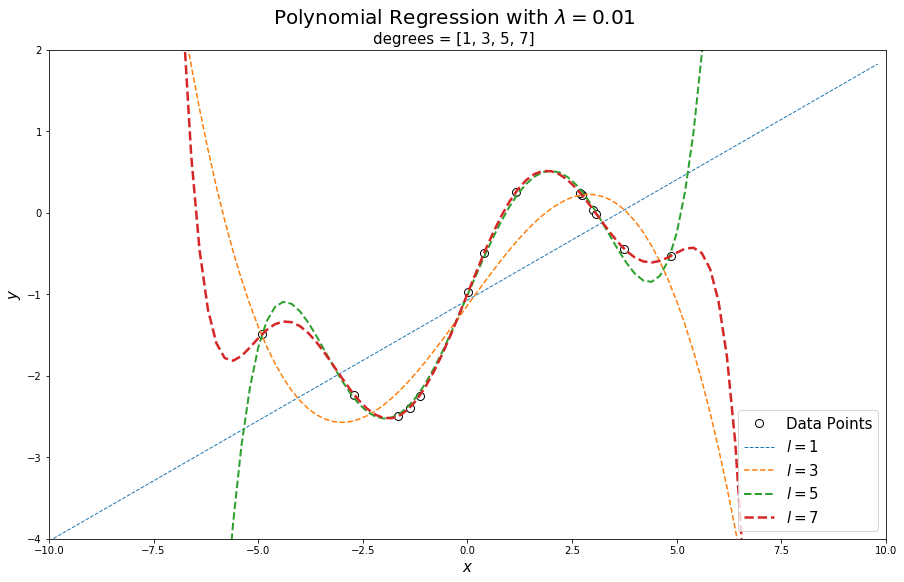

In [19]:
degrees = range(1,8,2)
lmbda = 0.01
plt.figure(figsize=(15,9))
plt.figtext(0.5, 0.92, 'Polynomial Regression with $\lambda = 0.01$', fontsize=20, ha='center')
plt.figtext(0.5, 0.89, 'degrees = %s'  % str(list(degrees)), fontsize=15, ha='center')
plt.xlim((-10,10))
plt.ylim((-4,2))
plt.xlabel("$x$", fontsize=15)
plt.ylabel("$y$", fontsize=15)
plt.plot(D_n[:, 0], D_n[:, 1], 'ko', markerfacecolor='w', markersize=8, label="Data Points")
lw = 1
for l in degrees:
    plot_pred_curve(D_n, l, lw=lw)
    lw += 0.5
plt.legend(loc=4, prop={'size': 15})
plt.savefig('q6plot')
plt.show()

## 7

* Plot the two risk on log scale

In [20]:
degrees = range(1,35)

In [21]:
emp_risks = []
true_risks = []
lmbda = 0.01
for l in degrees:
    X_n = np.hstack((np.ones((D_n.shape[0], 1)), preprocess(D_n[:, :-1], l)))
    X_test = np.hstack((np.ones((D_test.shape[0], 1)), 
                        preprocess(D_test[:, :-1], l)))
    y_n = D_n[:, -1]
    y_test = D_test[:, -1]
    I = np.eye(X_n.shape[1])
    I[0,0] = 0.
    theta = (np.linalg.inv(X_n.T @ X_n + (lmbda * I))
                             @ X_n.T @ y_n.reshape(-1,1)).ravel()
    emp_risk = np.sum(((X_n @ theta.reshape(-1,1)).ravel() - y_n) ** 2) / len(y_n)
    true_risk = np.sum(((X_test @ theta.reshape(-1,1)).ravel() - y_test) ** 2) / len(y_test)
    emp_risks.append(emp_risk)
    true_risks.append(true_risk)

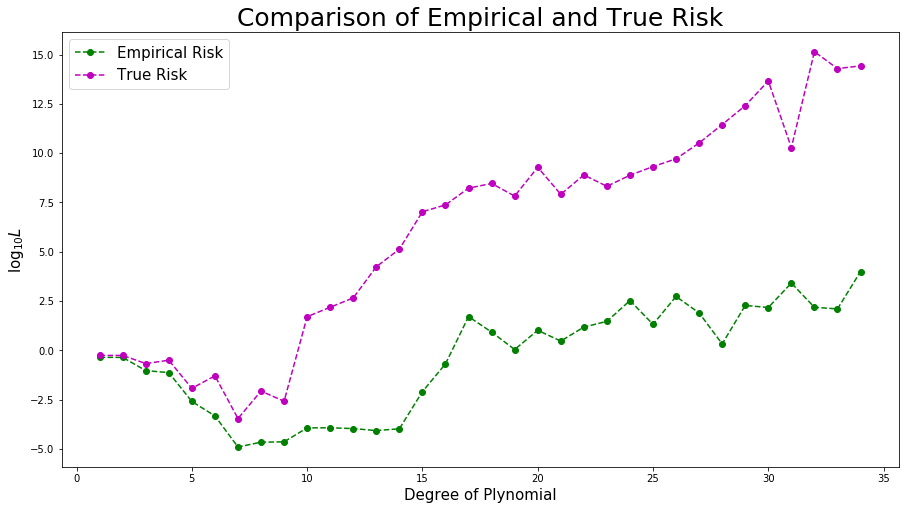

In [22]:
plt.figure(figsize=(15,8))
plt.title("Comparison of Empirical and True Risk", fontsize=25)
plt.plot(degrees, np.log10(emp_risks), 'go--', label='Empirical Risk')
plt.plot(degrees, np.log10(true_risks), 'mo--', label='True Risk')
plt.xlabel("Degree of Plynomial", fontsize=15)
plt.ylabel("$\log_{10} L$", fontsize=15)
plt.legend(loc=2, prop={'size': 15})
plt.savefig('q7plot')

Please see the PDF report for the detailed comments

In [11]:
reg = RegressionGradient(step_size=1000, l=3)
reg.train(D_n)

Starting the training process with stepsize = 1.0e+03 and lambda = 1.0e+00
Error found after 20 iterations. Retrying with new stepsize = 5.0e+02
Error found after 21 iterations. Retrying with new stepsize = 2.5e+02
Error found after 22 iterations. Retrying with new stepsize = 1.2e+02
Error found after 23 iterations. Retrying with new stepsize = 6.2e+01
Error found after 24 iterations. Retrying with new stepsize = 3.1e+01
Error found after 25 iterations. Retrying with new stepsize = 1.6e+01
Error found after 26 iterations. Retrying with new stepsize = 7.8e+00
Error found after 27 iterations. Retrying with new stepsize = 3.9e+00
Error found after 28 iterations. Retrying with new stepsize = 2.0e+00
Error found after 30 iterations. Retrying with new stepsize = 9.8e-01
Error found after 32 iterations. Retrying with new stepsize = 4.9e-01
Error found after 34 iterations. Retrying with new stepsize = 2.4e-01
Error found after 36 iterations. Retrying with new stepsize = 1.2e-01
Error found aft

In [14]:
from itertools import combinations_with_replacement

In [15]:
for i in combinations_with_replacement(range(1,4), 2):
    print(i)

(1, 1)
(1, 2)
(1, 3)
(2, 2)
(2, 3)
(3, 3)


In [17]:
def ngram_counts(corpus, n=2):
    d = defaultdict(int)
    for doc in corpus:
        words = doc.split()
        if len(words) < n:
            continue
        for i in range(len(words) - n):
            k = tuple(words[i+j] for j in range(n))
            d[k] += 1
    return d

In [20]:
tuple(2 for i in range(2))[0]

2

In [21]:
def ngram_counts(corpus, n=2):
    d = defaultdict(int)
    for doc in corpus:
        words = doc.split()
        if len(words) < n:
            continue
        for i in range(len(words) - n):
            k = tuple(words[i+j] for j in range(n))
            d[k] += 1
    return d

def missing_word(arglistseq, ngram_counts_list):
    d2 = defaultdict(int)
    d3 = defaultdict(int)
    d4 = defaultdict(int)
    d5 = defaultdict(int)
    for k in ngram_counts_list[3]:
        if (str(k[0]) == str(seq[0])) & (str(k[1]) == str(seq[1])) \
            & (str(k[3]) == str(seq[2])) & (str(k[4]) == str(seq[3])):
            d5[k[2]] += (ngram_counts_list[3])[k]
    s = '|'.join(e[0] for e in Counter(d5).most_common(10))
    if len(d5) >= 10:
        return s
    
    for k in ngram_counts_list[2]:
        if (str(k[0]) == str(seq[0])) & (str(k[1]) == str(seq[1])) & (str(k[3]) == str(seq[2])):
            if k[2] not in d5:
                d4[k[2]] += (ngram_counts_list[2])[k]
        if (str(k[0]) == str(seq[1])) & (str(k[2]) == str(seq[2])) & (str(k[3]) == str(seq[3])):
            if k[1] not in d5:
                d4[k[1]] += (ngram_counts_list[2])[k]
    if (s != '') & (len(d4) > 0):
        s += '|'
    s += '|'.join(e[0] for e in Counter(d4).most_common(10 - len(d5)))
    if len(d4) + len(d5) >= 10:
        return s
    
    for k in ngram_counts_list[1]:
        if (str(k[0]) == str(seq[1])) & (str(k[2]) == str(seq[3])):
            if (k[1] not in d4) & (k[1] not in d5):
                d3[k[1]] += (ngram_counts_list[1])[k]
        if (str(k[0]) == str(seq[0])) & (str(k[1]) == str(seq[1])):
            if (k[2] not in d4) & (k[2] not in d5):
                d3[k[2]] += (ngram_counts_list[1])[k]
        if (str(k[1]) == str(seq[2])) & (str(k[2]) == str(seq[3])):
            if (k[0] not in d4) & (k[0] not in d5):
                d3[k[0]] += (ngram_counts_list[1])[k]
    if s != '':
        s += '|'
    s += '|'.join(e[0] for e in Counter(d3).most_common(10 - len(d4) - len(d5)))
    return s

def missing_word3(seq, ngram_counts_list):
    d3 = defaultdict(int)
    for k in ngram_counts_list[3]:
        if (str(k[0]) == str(seq[1])) & (str(k[2]) == str(seq[1])):
            d3[k[1]] += (ngram_counts_list[1])[k]
    s = '|'.join(e[0] for e in Counter(d3).most_common(10))
    return s

In [ ]:
def missing_word3(seq, ngram_counts_list):
    d3 = defaultdict(int)
    for k in ngram_counts_list[3]:
        if (str(k[0]) == str(seq[1])) & (str(k[2]) == str(seq[1])):
            d3[k[1]] += (ngram_counts_list[1])[k]
    s = '|'.join(e[0] for e in Counter(d3).most_common(10))
    return s

In [ ]:
import codecs
import re
import pickle
from collections import defaultdict, Counter

def ngram_counts(corpus, n=2):
    d = defaultdict(int)
    for doc in corpus:
        words = doc.split()
        if len(words) < n:
            continue
        for i in range(len(words) - n):
            k = tuple(words[i+j] for j in range(n))
            d[k] += 1
    return d

def missing_word(arglistseq, ngram_counts_list):
    d2 = defaultdict(int)
    d3 = defaultdict(int)
    d4 = defaultdict(int)
    d5 = defaultdict(int)
    for k in ngram_counts_list[3]:
        if (str(k[0]) == str(seq[0])) & (str(k[1]) == str(seq[1])) \
            & (str(k[3]) == str(seq[2])) & (str(k[4]) == str(seq[3])):
            d5[k[2]] += (ngram_counts_list[3])[k]
    s = '|'.join(e[0] for e in Counter(d5).most_common(10))
    if len(d5) >= 10:
        return s
    
    for k in ngram_counts_list[2]:
        if (str(k[0]) == str(seq[0])) & (str(k[1]) == str(seq[1])) & (str(k[3]) == str(seq[2])):
            if k[2] not in d5:
                d4[k[2]] += (ngram_counts_list[2])[k]
        if (str(k[0]) == str(seq[1])) & (str(k[2]) == str(seq[2])) & (str(k[3]) == str(seq[3])):
            if k[1] not in d5:
                d4[k[1]] += (ngram_counts_list[2])[k]
    if (s != '') & (len(d4) > 0):
        s += '|'
    s += '|'.join(e[0] for e in Counter(d4).most_common(10 - len(d5)))
    if len(d4) + len(d5) >= 10:
        return s
    
    for k in ngram_counts_list[1]:
        if (str(k[0]) == str(seq[1])) & (str(k[2]) == str(seq[3])):
            if (k[1] not in d4) & (k[1] not in d5):
                d3[k[1]] += (ngram_counts_list[1])[k]
        if (str(k[0]) == str(seq[0])) & (str(k[1]) == str(seq[1])):
            if (k[2] not in d4) & (k[2] not in d5):
                d3[k[2]] += (ngram_counts_list[1])[k]
        if (str(k[1]) == str(seq[2])) & (str(k[2]) == str(seq[3])):
            if (k[0] not in d4) & (k[0] not in d5):
                d3[k[0]] += (ngram_counts_list[1])[k]
    if s != '':
        s += '|'
    s += '|'.join(e[0] for e in Counter(d3).most_common(10 - len(d4) - len(d5)))
    return s

def missing_word3(seq, ngram_counts_list):
    d3 = defaultdict(int)
    for k in ngram_counts_list[3]:
        if (str(k[0]) == str(seq[1])) & (str(k[2]) == str(seq[1])):
            d3[k[1]] += (ngram_counts_list[1])[k]
    s = '|'.join(e[0] for e in Counter(d3).most_common(10))
    return s

n = '20c'

with codecs.open('/u/majumdta/TP/TP1/t-unk-europarl-v7.fi-en-u%s.en' % n, 
                 encoding='latin-1') as f:
    test_corpus = [re.sub(r'[^\w\s]', '', line).strip(' \n').lower() 
                   for line in f]

unks = []
with codecs.open('/u/majumdta/TP/TP1/unk-europarl-v7.fi-en-u%s.en' % n, 
                 encoding='latin-1') as f:
    for line in f:
        unks.extend(re.findall(r'<unk w=\"(.*?)\"/>', line))

seqs = []
for doc in test_corpus:
    words = doc.split()
    idx = [i for i, x in enumerate(words) if x == "unk"]
    for i in idx:
        if (i < 1) or (i > len(words) - 2):
            seqs.append(['UNK'])
        elif i == 1:
            seqs.append([words[0], words[2]])
        elif i == len(words) - 2:
            seqs.append([words[-3], words[-1]])
        else:
             seqs.append(words[(i-2):i] + words[(i+1):(i+3)])

assert len(unks) == len(seqs)
tuples = list(i for i in zip(['|'.join(seq) for seq in seqs], unks))

with open('counts.pickle', 'rb') as fp:
    d1=pickle.load(fp)
    d2=pickle.load(fp)
    d3=pickle.load(fp)
    d4=pickle.load(fp)
ngram_counts_list = [d1, d2, d3, d4]

for s, tgt in tuples[:100]:
    seq = s.split('|')
    if len(seq) == 1:
        with open('results%s.txt' % n, 'a') as f:
            f.write(s + '\t' + tgt + '\n')
    elif len(seq) == 2:
        with open('results%s.txt' % n, 'a') as f:
            f.write(missing_word3(seq, ngram_counts_list) + '\t' + tgt + '\n')
    else:
        with open('results%s.txt' % n, 'a') as f:
            f.write(missing_word(seq, ngram_counts_list) + '\t' + tgt + '\n')

In [ ]:
import codecs
import re
import pickle
from collections import defaultdict, Counter

data_dir = "/u/majumdta/TP/TP1"
def find_accuracy(n):
    tfile = data_dir + "/t-unk-europarl-v7.fi-en-u%s.en" % n
    ufile = data_dir + "/unk-europarl-v7.fi-en-u%s.en" % n
    
    with codecs.open(tfile, encoding='latin-1') as f:
        test_corpus = [re.sub(r'[^\w\s]', '', line)\
                           .strip(' \n').lower().split() for line in f]
    
    seqs = []
    for words in test_corpus:
        idx = [i for i, x in enumerate(words) if x == "unk"]
        for i in idx:
            if i == 0:
                seqs.append(words[1:3])
            elif i == len(words) - 1:
                seqs.append(words[-3:-1])
            elif i == 1:
                seqs.append([words[0]] + words[2:4])
            elif i == len(words) - 2:
                seqs.append(words[-4:-2] + [words[-1]])
            else:
                seqs.append(words[(i-2):i] + words[(i+1):(i+3)])
    
    unks = []
    with codecs.open(ufile, encoding='latin-1') as f:
        for line in f:
            unks.extend(re.findall(r'<unk w=\"(.*?)\"/>', line))

    tuples = list(zip(seqs, unks))
    
    i = 0
    for s, t in tuples:
        try:
            if t.lower() in set([e[0] for e in tmp.predict_output_word(s)]):
                i += 1
        except:
            pass
    
    print("File %s: Accuracy: %0.3f" % (n, i / len(unks)))

In [3]:
import numpy as np
np.ones((3,3,3))

array([[[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]]])